In [1]:
# Import modules
import os,glob
import matplotlib
# For interactive jupyter lab notebook plots:
#%matplotlib ipympl
# Simple inline with no plot interaction
#%matplotlib inline
# For exporting and standalone graphics
#matplotlib.use('Tkagg')
from matplotlib import pyplot as plt
import numpy as np

from astropy.io import fits
from astropy.wcs import WCS

plt.rcParams['font.family'] = 'serif'

# Needed to ensure that the figure canvas is properly set. It may be messed up in a jupyter lab notebook
def fix_canvas(current_fig):
    if 'ipympl' in matplotlib.get_backend(): 
        current_fig.canvas.layout.width = '{:}in'.format(current_fig.get_figwidth())
        current_fig.canvas.layout.height= '{:}in'.format(current_fig.get_figheight())

In [2]:
# Load data image data and print some basic data

# N2337
url = 'https://hla.stsci.edu/cgi-bin/getdata.cgi?config=ops&download=1&dataset=hst_13442_95_acs_wfc_f814w&filename=hst_13442_95_acs_wfc_f814w_drz.fits'

# Use the image faile name as a root name for the files to be saved
if '/' in url: filename = url[url.rfind('/')+1:url.rfind('.fits')]
if 'hla.stsci' in url: filename = url[url.rfind('=')+1:url.rfind('.fits')]

if 'data' in locals() or 'data' in globals(): del data,data_hdr,wcs

hdu = fits.open(url)
wcs = WCS(hdu[1].header)
data = fits.getdata(url) # hdu[0].data
data_hdr = fits.getheader(url)
#wcs = WCS(data_hdr)
    
#data = np.ma.masked_invalid(data)
data = np.ma.masked_equal(data,-0.)
data = np.ma.masked_invalid(data)

print('min={:.2f}, max={:.2f}, EXPTIME={:.2f}\
'.format(data.min(),data.max(),data_hdr['EXPTIME']))
data_hdr.get('*object*'),data_hdr.get('*date*'),data_hdr.get('*instr*'),data_hdr.get('*detect*'),\
data_hdr.get('*scal*'),data_hdr.get('*gai*'),data_hdr.get('*readn*'),data_hdr.get('*sky*'),\
data_hdr.get('*filt*'),data_hdr.get('*targ*'),data_hdr.get('*combi*'),data_hdr.get('*uni*')

min=-0.04, max=293.23, EXPTIME=1000.00


(,
 DATE    = '2017-08-17         ' / Date FITS file was generated                  
 DATE-OBS= '2013-12-17'         / UT date of start of observation (yyyy-mm-dd)   ,
 INSTRUME= 'ACS   '             / identifier for instrument used to acquire data ,
 DETECTOR= 'WFC'                / detector in use: WFC, HRC, or SBC              ,
 SCALENSE=             0.000000 / multiplicative scale factor applied to noise   
 D001SCAL=                 0.05 / Drizzle, pixel size (arcsec) of output image   
 D002SCAL=                 0.05 / Drizzle, pixel size (arcsec) of output image   
 D003SCAL=                 0.05 / Drizzle, pixel size (arcsec) of output image   
 D004SCAL=                 0.05 / Drizzle, pixel size (arcsec) of output image   ,
 CCDGAIN =                  2.0 / commanded gain of CCD                          ,
 READNSEA=        4.3499999E+00 / calibrated read noise for amplifier A          
 READNSEB=        3.7500000E+00 / calibrated read noise for amplifier B          
 READNSE

In [3]:
# ONLY FOR ACS & WFC3 HLA products!!! Convert from electrons/sec to data counts. Execute ONCE per data read 

exptime = data_hdr['EXPTIME']

data = data * exptime / float(input('WARNING! Divide the exptime by the number of combined frames: 1.') or 1.)
print('min={:.2f}, max={:.2f}'.format(data.min(),data.max()))

WARNING! Divide the exptime by the number of combined frames: 1. 4.


min=-11.06, max=73307.45


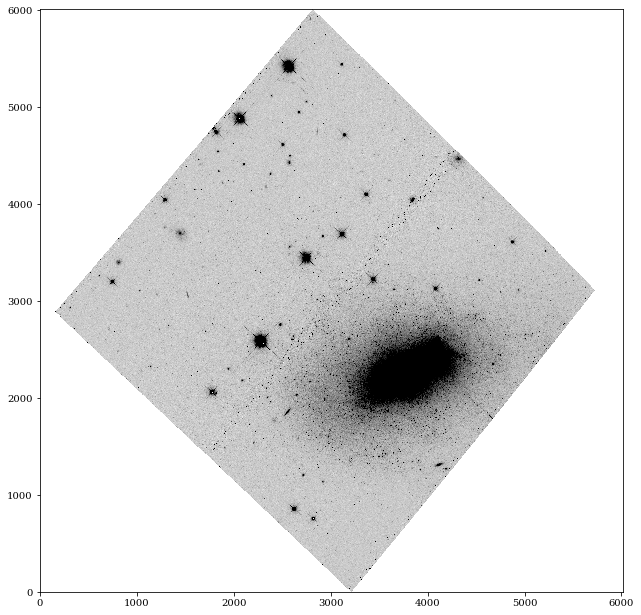

In [4]:
# (OPTIONAL) Display the image 

if 'fig1' in locals() or 'fig1' in globals(): plt.close(fig1)
fig1 = plt.figure(1,figsize=(9,9))
# Needed to ensure that the figure canvas is properly set. It may be messed up in a jupyter lab notebook
fix_canvas(fig1)

fig1_ax1 = fig1.add_axes([.05,.05,.9,.9]) #,projection=wcs)

fig1_ax1.imshow(data, origin = 'lower', vmin=0., vmax = data.mean()*2, cmap = 'Greys')

In [5]:
# Find stars in the image

from photutils.detection import DAOStarFinder

dao_find = DAOStarFinder(threshold=100, fwhm=2.0, peakmax=9e4, sigma_radius=6, exclude_border=True, sharplo=0.6, sharphi=1.05, roundlo=-.1, roundhi=0.2) #, brightest=250)

In [6]:
stars_tbl = dao_find(data)
print('Found {:} stars'.format(len(stars_tbl['id'])))
stars_tbl.sort('mag')

Found 844 stars


In [7]:
stars_tbl.columns

<TableColumns names=('id','xcentroid','ycentroid','sharpness','roundness1','roundness2','npix','sky','peak','flux','mag')>

In [9]:
# Visualize in the above plot (in interactive only) the preselected stars

# Explicitly exclude stars that are too close to the image boundaries, because they cannot be extracted.

size = 25
hsize = (size - 1) / 2
x = stars_tbl['xcentroid']  
y = stars_tbl['ycentroid']  

# Filter by property
xcen=3800 ; ycen=2300

round1=.15; round2=.15; sharp=0.85; mag_faint_inst = -2.0

mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) & \
        (y > hsize) & (y < (data.shape[0] -1 - hsize)) & \
        (np.sqrt((x-xcen)**2 + (y-ycen)**2)>=1000) & \
        (stars_tbl['mag']<=mag_faint_inst) & \
        (stars_tbl['sharpness']>=sharp) & \
        (abs(stars_tbl['roundness1'])<=round1) & \
        (abs(stars_tbl['roundness2'])<=round2))
    
temp_tbl = stars_tbl[mask].copy()

print('Selected {:} stars out of {:} initially detected'.format(len(temp_tbl['id']),len(stars_tbl['id'])))

fig1_ax1.plot(stars_tbl['xcentroid'],stars_tbl['ycentroid'],'o',alpha=0.25, color='cyan')
fig1_ax1.plot(temp_tbl['xcentroid'],temp_tbl['ycentroid'],'o',alpha=0.25, color='red')

Selected 50 stars out of 844 initially detected


N good stars: 31
N bad: 0


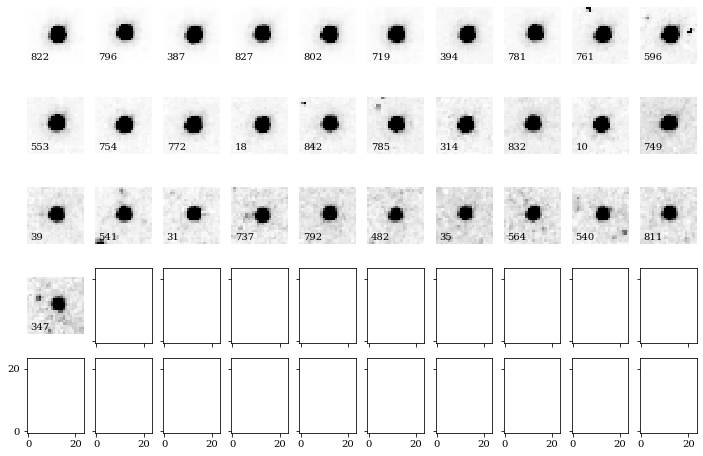

In [12]:
# Selecting EPSFStars, from which we’ll build our ePSF
from astropy.stats import sigma_clipped_stats

# Choose which stars to treat as good, if the sigma clipped stats of the star box are within mean_median_factor. Large factor does not exclude stars, e.g. 1e3.
# 
mean_median_factor = 1.3 # 1e3 # 

i=0
good_list_count = []
good_list = []
bad_list = []
# Needed in order to locate the index of a column
temp_tbl.add_index('id')

for epsf_star in temp_tbl:
    epsf_star_data = data[int(epsf_star['ycentroid']-12):int(epsf_star['ycentroid']+12),int(epsf_star['xcentroid']-12):int(epsf_star['xcentroid']+12)].copy()
    mean, median, std = sigma_clipped_stats(epsf_star_data, sigma=3.0)
    if std <= mean*mean_median_factor and std <= median*mean_median_factor:
        #print(epsf_star.id_label, mean, median, std,epsf_star.data.min())
        good_list_count.append(i)
        good_list.append(int(epsf_star['id']))
    else:
        bad_list.append(epsf_star['id'])
#        print(epsf_star['id'], end=', ')
#        temp_tbl.remove_row(temp_tbl.loc[int(epsf_star['id'])].index)
    i+=1
print('N good stars: {:}\nN bad: {:}'.format(len(good_list),len(bad_list)))

#from astropy.visualization import simple_norm
ncols = 10
if round(len(good_list_count)/ncols)<=2 :
    nrows = round(len(good_list_count)/ncols)
else:
    nrows = 5

#nrows = 5
if 'fig3' in globals(): plt.close(fig=fig3)
fig3, ax = plt.subplots(nrows=nrows, ncols=ncols, squeeze=True,figsize=(12,8),sharex=True, sharey=True)
fix_canvas(fig3)

ax = ax.ravel()
for i,epsf_star in zip(range(len(good_list_count)),range(len(temp_tbl['id']))):
    epsf_star = temp_tbl[epsf_star]
    epsf_star_data = data[int(epsf_star['ycentroid']-12):int(epsf_star['ycentroid']+12),int(epsf_star['xcentroid']-12):int(epsf_star['xcentroid']+12)].copy()
    ax[i].imshow(epsf_star_data, vmin=epsf_star_data.min(), vmax=epsf_star_data.mean()*2, origin='lower', cmap='Greys') # norm=norm, 
    ax[i].text(1,1,'{:}'.format(epsf_star['id']))
    ax[i].axis('off')


In [11]:
# Manually remove bad stars from the list above and re run the plot
# 
bad_list = [586,821,759,782,313,4,644,788,755,734,713,731,11,308,666,192,7,823,712]

for star_id in bad_list:
    temp_tbl.remove_row(temp_tbl.loc[star_id].index) 


In [13]:
# The star cutouts from which we build the ePSF must be background subtracted. 

from photutils import make_source_mask
from photutils import Background2D, MedianBackground

print('Calculating sigma clipped stats for source detection and masking')
mask = make_source_mask(data, nsigma=3, npixels=3, dilate_size=11,)
mean, median, std = sigma_clipped_stats(data, sigma=3.0, mask=mask)

print((mean, median, std)) 
# Additional mask if needed
# mask = (data == 0)

Calculating sigma clipped stats for source detection and masking
(18.71497917175293, 19.934473037719727, 2.982595920562744)


In [14]:
print('Calculating 2D background estimate on a smoothed and subgrided sections of the image')
bkg = Background2D(data, (25, 25), filter_size=(3, 3)) #, mask=mask)

# Applying the mask to the returned background image
bkg_img = bkg.background * ~mask

Calculating 2D background estimate on a smoothed and subgrided sections of the image


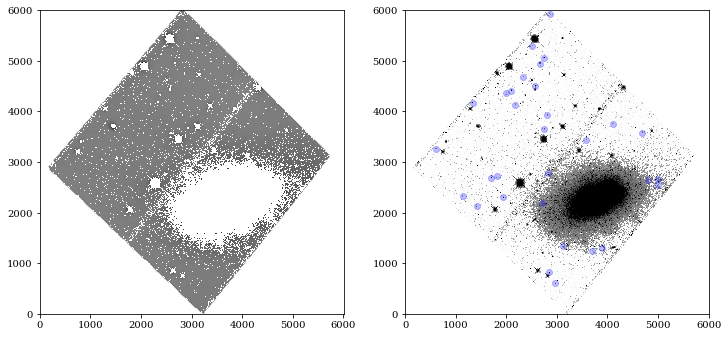

In [15]:
# (OPTIONAL) Display the background and the residual

if 'fig2' in globals() or 'fig2' in locals(): plt.close(fig2)
fig2 = plt.figure(2,figsize=(2*6,6))
# Needed to ensure that the figure canvas is properly set. It may be messed up in a jupyter lab notebook
fix_canvas(fig2)

fig2_ax1 = fig2.add_subplot(1,2,1) #, position=[.0,.1,.9,.9]) #,projection=wcs)
fig2_ax2 = fig2.add_subplot(1,2,2) #, position=[.25,.1,.9,.9]) #,projection=wcs)

fig2_ax1.imshow(bkg_img, origin = 'lower', vmin=0, vmax = bkg_img.max(), cmap = 'Greys')
fig2_ax2.imshow(data - bkg_img, origin = 'lower', vmin=0, vmax = (data - bkg_img).mean()*3, cmap = 'Greys')

# Overplot the preselected PSF stars
fig2_ax2.plot(temp_tbl['xcentroid'],temp_tbl['ycentroid'],'o',alpha=0.25, color='blue')

In [16]:
# Extracting the stars requires that the input table has column names x,y for the star's positions
# We're also saving the ePSF stars to a file

ePSF_stars_tbl = temp_tbl.copy()
ePSF_stars_tbl.rename_columns(['xcentroid', 'ycentroid'], ['x','y'])
ePSF_stars_tbl.write('{:}_ePSF_stars.dat'.format(filename), format='ascii', overwrite=True)

In [17]:
# The extract_stars() function requires the input data as an NDData object. 
from astropy.nddata import NDData
nddata = NDData(data=data-bkg_img)  

# Extract the pixel cutouts of the selected stars:

from photutils.psf import extract_stars
ePSF_stars = extract_stars(nddata, ePSF_stars_tbl, size=25)


In [18]:
from photutils import EPSFBuilder,EPSFFitter
from photutils import centroids
from astropy.modeling.fitting import SLSQPLSQFitter,SimplexLSQFitter

#centroids.centroid_1dg # Calculate the centroid of a 2D array by fitting 1D Gaussians to the marginal x and y distributions of the array.
#centroids.centroid_2dg # Calculate the centroid of a 2D array by fitting a 2D Gaussian (plus a constant) to the array.
#centroids.centroid_com # Calculate the centroid of an n-dimensional array as its “center of mass” determined from moments.
#centroids.centroid_epsf # Calculates centering shift of data using pixel symmetry, as described by Anderson and King (2000; PASP 112, 1360) in their ePSF-fitting algorithm.
#centroids.centroid_sources # Calculate the centroid of sources at the defined positions.
#centroids.fit_2dgaussian # Fit a 2D Gaussian plus a constant to a 2D image.
#centroids.gaussian1d_moments # Estimate 1D Gaussian parameters from the moments of 1D data.

new_fitter = EPSFFitter(fit_boxsize=9) #,fitter=SLSQPLSQFitter())

epsf_builder = EPSFBuilder(oversampling=2, maxiters=3, recentering_maxiters=3, recentering_func=centroids.centroid_com, \
                           shift_val=0.01, fitter=new_fitter, progress_bar=True,smoothing_kernel='quartic')

# Modify the clipping values
epsf_builder.sigclip.maxiters=2
epsf_builder.sigclip.sigma=5.0
epsf_builder.sigclip.sigma_lower=2.
epsf_builder.sigclip.sigma_upper=5.

epsf, fitted_stars = epsf_builder(ePSF_stars)
epsf.data.max()

0.18662833202287957

In [19]:
from astropy.modeling import models, fitting

epsf_x,epsf_y=np.mgrid[:np.shape(epsf.data)[0],:np.shape(epsf.data)[1]]

g_init = models.Gaussian2D(amplitude=epsf.data.max(),x_mean=epsf.x_origin,y_mean=epsf.y_origin,x_stddev=1.5,y_stddev=1.5, theta=.5)
fit_g = fitting.LevMarLSQFitter()
g2d = fit_g(g_init, x=epsf_x, y=epsf_y, z=epsf.data)

mof_init = models.Moffat2D(amplitude=epsf.data.max(),x_0=epsf.x_origin,y_0=epsf.y_origin,alpha=2.5,gamma=1.55)
fit_mof = fitting.LevMarLSQFitter()
mof2d = fit_mof(mof_init, x=epsf_x, y=epsf_y, z=epsf.data)

# Composite
g_m_init = models.Gaussian2D(amplitude=g2d.amplitude.value/2,x_mean=epsf.x_origin,y_mean=epsf.y_origin,x_stddev=1.5,y_stddev=1.5, theta=.5) + \
models.Moffat2D(amplitude=mof2d.amplitude.value/2.,x_0=epsf.x_origin,y_0=epsf.y_origin,alpha=2.5,gamma=1.55)

fit_g_m = fitting.LevMarLSQFitter()
g_m_2d = fit_g_m(g_m_init, x=epsf_x, y=epsf_y, z=epsf.data)

(-0.5, 50.5, -0.5, 50.5)

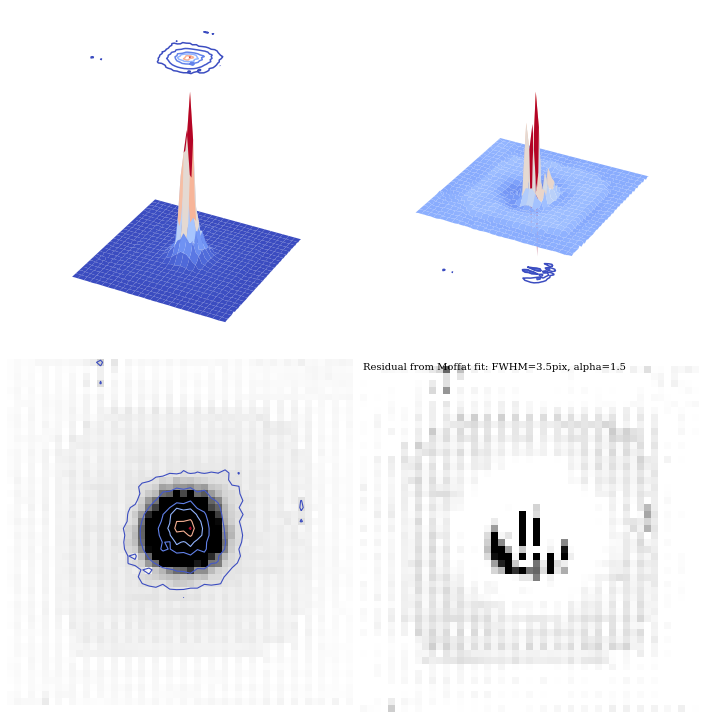

In [20]:
# Create a mesh plot from a selected region around the target

# Needed for the 3D mesh plot
from mpl_toolkits.mplot3d import Axes3D

# Create the meshgrid in x,y needed for the 3D
ny , nx = epsf.data.shape
x = np.arange(0,nx,1)
y = np.arange(0,ny,1)
xv, yv = np.meshgrid(x,y)

if 'fig4' in locals() or 'fig4' in globals(): plt.close(fig4)
fig4 = plt.figure(4,figsize=(9.8,9.8))

# Needed to ensure that the figure canvas is properly set. It may be messed up in a jupyter lab notebook
fix_canvas(fig4)

#fig4_ax = fig4.add_axes([.05,.05,.9,.9])
fig4_ax = fig4.add_subplot(2,2,1, position=[.01,.01,.5,.5])
fig4_ax2 = fig4.add_subplot(2,2,2, projection='3d', position=[.01,.5,.5,.5])
fig4_ax3 = fig4.add_subplot(2,2,3, projection='3d', position=[.5,.5,.5,.5])
fig4_ax4 = fig4.add_subplot(2,2,4, position=[.5,.0,.5,.5])

fig4_ax.imshow(epsf.data, origin='lower',vmin=0,vmax=epsf.data.mean()*5, cmap='Greys')
fig4_ax.contour(epsf.data, levels=[epsf.data.mean()*1,epsf.data.mean()*3,epsf.data.mean()*10,epsf.data.mean()*20,epsf.data.mean()*50,epsf.data.max()*.95], linewidths=1.1, cmap='coolwarm')
fig4_ax.axis('off')

fig4_ax2.plot_surface(xv,yv,epsf.data, cmap='coolwarm',rcount=50,ccount=50)
fig4_ax2.view_init(elev=30, azim=208)
fig4_ax2.contour(xv,yv,epsf.data, zdir='z', offset=epsf.data.max()*1.2, \
                 levels=[epsf.data.mean()*1,epsf.data.mean()*3,epsf.data.mean()*10,epsf.data.mean()*20,epsf.data.mean()*50,epsf.data.max()*.95], \
                 cmap='coolwarm')
fig4_ax2.axis('off')

fig4_ax3.plot_surface(xv,yv,epsf.data-mof2d(epsf_x,epsf_y), cmap='coolwarm',rcount=50,ccount=50)
fig4_ax3.view_init(elev=30, azim=208)
fig4_ax3.contour(xv,yv,epsf.data-mof2d(epsf_x,epsf_y), zdir='z', offset=(epsf.data-mof2d(epsf_x,epsf_y)).min()*1.2, \
                 levels=[epsf.data.mean()*1,epsf.data.mean()*3,epsf.data.mean()*10,epsf.data.mean()*20,epsf.data.mean()*50,epsf.data.max()*.95], \
                 cmap='coolwarm')
fig4_ax3.axis('off')

#fig4_ax3.imshow(epsf.data-g2d(epsf_x,epsf_y), origin='lower',vmin=0,vmax=(epsf.data-g2d(epsf_x,epsf_y)).mean()*5, cmap='Greys',\
#                label='Gaussian fit: $\sigma_x$={:.1f}, $\sigma_y$={:.1f}'.format(g2d.x_stddev.value, g2d.y_stddev.value))
fig4_ax4.imshow(epsf.data-mof2d(epsf_x,epsf_y), origin='lower',vmin=(epsf.data-mof2d(epsf_x,epsf_y)).mean(),vmax=(epsf.data-mof2d(epsf_x,epsf_y)).mean()*10, cmap='Greys',\
                label='Moffat fit: FWHM={:.1f}'.format(mof2d.fwhm))
fig4_ax4.text(1,epsf.data.shape[0]-2,'Residual from Moffat fit: FWHM={:.1f}pix, alpha={:.1f}'.format(mof2d.fwhm,mof2d.alpha.value))
fig4_ax4.axis('off')


In [21]:
# (Optional) Save the figure 
fig_file_name = '{:s}_ePSF.pdf'.format(filename)
fig4.savefig(fig_file_name,\
            format='pdf',transparent=True,dpi=120,bbox_inches='tight')
print('Saved figure {:s}'.format(fig_file_name))
os.system('pdfcrop {:} {:}'.format(fig_file_name,fig_file_name))
os.system('open {:}'.format(fig_file_name))

Saved figure hst_13442_95_acs_wfc_f814w_drz_ePSF.pdf


0

In [22]:
# Save the ePSF as a fits file
ePSF_file_name = '{:s}_ePSF.fits'.format(filename)
fits.writeto(ePSF_file_name,data=epsf.data,overwrite=True)

In [23]:
# Add information about the ePSF builder parameters used to generate the ePSF

#i=0
with fits.open(ePSF_file_name, 'update') as f:
    for hdu in f:
        hdu.header['Comment'] = 'ePSF for {:}'.format(filename)
        hdu.header['Comment'] = 'epsf_builder parameters:'
        for param in epsf_builder.__dict__:
            line1 = str(param).strip('_,:,>,<')
            line2 = str(epsf_builder.__dict__[param]).strip(r'],[_,:,>,<,\n')
#            print(line1,line2.split())
            hdu.header['Comment']=('{:} / {:}'.format(line1,line2.split()))
#        for star_xy in fitted_stars.center_flat:
#            hdu.header['Star{:}'.format(i)]=('{:}'.format(str(star_xy)),'epsf_builder star')
#            i+=1

In [24]:
# (Optional) Have a look at the header

print(repr(fits.getheader(ePSF_file_name)))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   51                                                  
NAXIS2  =                   51                                                  
EXTEND  =                    T                                                  
COMMENT ePSF for hst_13442_95_acs_wfc_f814w_drz                                 
COMMENT epsf_builder parameters:                                                
COMMENT norm_radius / ['5.5']                                                   
COMMENT shift_val / ['0.01']                                                    
COMMENT oversampling / ['2', '2']                                               
COMMENT shape / ['None']                                                        
COMMENT recentering_func / [

# Perform basic PSF fitting photometry on the ePSF stars

In [25]:
from photutils.psf import (IterativelySubtractedPSFPhotometry,
                           BasicPSFPhotometry)
from photutils import MMMBackground
from photutils.psf import IntegratedGaussianPRF, DAOGroup
#from photutils.detection import DAOStarFinder
from astropy.table import Table
from astropy.modeling.fitting import LevMarLSQFitter



daogroup = DAOGroup(crit_separation=8)
mmm_bkg = MMMBackground()

fitter = LevMarLSQFitter()
#gaussian_prf = IntegratedGaussianPRF(sigma=1.95)
#gaussian_prf.sigma.fixed = False
ePSF_model = epsf
#itr_phot_obj = IterativelySubtractedPSFPhotometry(aperture_radius=5,
#                                                  finder=dao_find,
#                                                  group_maker=daogroup,
#                                                  bkg_estimator=mmm_bkg,
#                                                  psf_model=ePSF_model,
#                                                  fitter=fitter,
#                                                  fitshape=(11, 11),
#                                                  niters=2)

phot_obj = BasicPSFPhotometry(aperture_radius=5,
                              finder=None,
                              group_maker=daogroup,
                              bkg_estimator=mmm_bkg,
                              psf_model=ePSF_model,
                              fitter=fitter,
                              fitshape=(11, 11))

In [26]:
# Performing PSF photometry on a specific list of objects from a table, requires a bit table modification.
# It must contain sequenced stellar IDs and column names x_0,y_0

# Use the ePSF_stars_tbl 

phot_obj_tbl = Table(ePSF_stars_tbl,copy=True,copy_indices=False)
phot_obj_tbl.rename_columns(['x', 'y'], ['x_0','y_0'])

for i in range(1,len(phot_obj_tbl['id'])+1):
    phot_obj_tbl['id'][i-1]=i


In [27]:
# BasicPSFPhotometry on the list of ePSF stars

# Uncomment the lines below to use the DAOStarFinder table as an input
#
#phot_obj_tbl = stars_tbl.copy()
#if 'x_0' not in phot_obj_tbl.colnames and 'y_0' not in phot_obj_tbl.colnames :
#    phot_obj_tbl.rename_columns(['xcentroid', 'ycentroid'], ['x_0','y_0'])

phot_results = phot_obj(data,init_guesses=phot_obj_tbl)

In [28]:
phot_results.columns
#itr_phot_results.columns

<TableColumns names=('id','x_0','y_0','sharpness','roundness1','roundness2','npix','sky','peak','flux','mag','flux_0','group_id','x_fit','y_fit','flux_fit','flux_unc','x_0_unc','y_0_unc')>

In [29]:
#phot_results.columns
phot_results_rsd_img = phot_obj.get_residual_image()

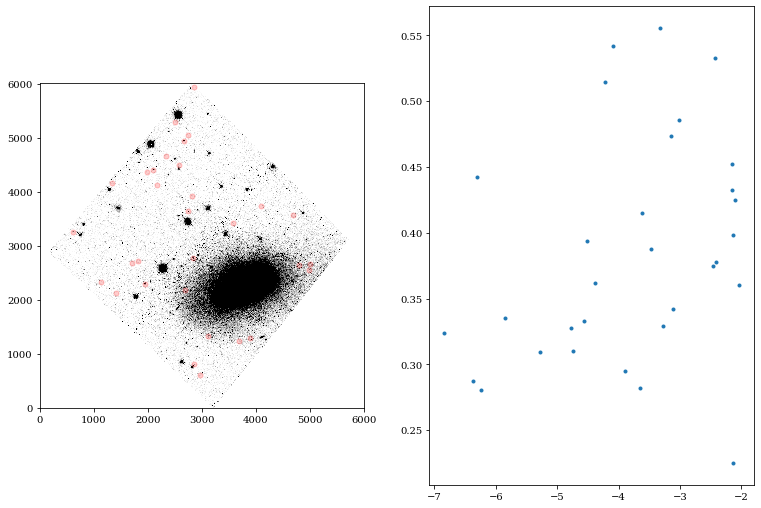

In [30]:
# Have a look at the residuals

if 'fig5' in locals() or 'fig5' in globals(): plt.close(fig5)
fig5 = plt.figure(5,figsize=(12.8,8.8))

# Needed to ensure that the figure canvas is properly set. It may be messed up in a jupyter lab notebook
fix_canvas(fig5)

fig5_ax1 = fig5.add_subplot(121)
fig5_ax2 = fig5.add_subplot(122)

fig5_ax1.imshow(phot_results_rsd_img, origin='lower', cmap='Greys', vmin=phot_results_rsd_img.mean()*.05, vmax=phot_results_rsd_img.mean()*1.5)
fig5_ax1.plot(phot_results['x_fit'],phot_results['y_fit'],'o',ms=5,color='red', alpha=.2)

selection = (phot_results['x_0']==stars_tbl['xcentroid']) & (phot_results['y_0']==stars_tbl['ycentroid'])
#selection = (phot_results['x_fitt']==ePSF_stars_tbl['x']) & (phot_results['y_fit']==ePSF_stars_tbl['y'])
fig5_ax2.plot(phot_results['mag'],phot_results['flux_unc']/(2.5*np.log(10)*phot_results['flux']*np.log10(data_hdr['EXPTIME'])),'.')
#fig5_ax2.imshow(itr_phot_result_rsd_img, origin='lower', cmap='Greys')
